In [2]:
import numpy
import pandas
import morphio
import conntility
import os

root_morph = "/gpfs/bbp.cscs.ch/project/proj161/skeletonization/microns_mm3/output/10-vpm/morphologies"
conn_fn = "/gpfs/bbp.cscs.ch/home/reimann/data/mm3/microns_mm3_connectome.h5"

Load the synapses that have been isolated in MICrONS

In [ ]:
M = conntility.ConnectivityMatrix.from_h5(conn_fn, "full")

Generate a pandas.Series that tells us for each pt_root_id where to find the associated skeletonized morphologies

In [3]:
def dir_to_series(root):
    fns = [_x for _x in os.listdir(root) if 
           os.path.isfile(os.path.join(root, _x)) and 
           os.path.splitext(_x)[1] == ".swc"]
    return pandas.Series([
        os.path.join(root, _x) for _x in fns
    ], index=[
        int(os.path.splitext(_x)[0]) for _x in fns
    ])

morph_series = dir_to_series(root_morph)

morph_series.head()

864691135571017453    /gpfs/bbp.cscs.ch/project/proj161/skeletonizat...
864691135939606529    /gpfs/bbp.cscs.ch/project/proj161/skeletonizat...
864691135348510679    /gpfs/bbp.cscs.ch/project/proj161/skeletonizat...
864691136333967283    /gpfs/bbp.cscs.ch/project/proj161/skeletonizat...
864691135567953132    /gpfs/bbp.cscs.ch/project/proj161/skeletonizat...
dtype: object

Here comes the most important part.

A number of functions that map the incoming and outgoing synapses of a neuron to its skeletonized morphology.
That is, for synapse it find the closest point on the morphology and returns the section id, segment id and within-segment offset of that point.

In [4]:
from scipy.spatial import distance

def morphology(pt_root_id):
    m = morphio.Morphology(pt_root_id)
    return m

def point_segment_distances(sec_pts, syn_locs):
    """
    Calculates the pairwise distances from line segments of a morphological section
    to synapse locations. Both are given as points in 3d space.
    
    Args:
      sec_pts: N x 3 numpy array. Coordinates of reconstructed section points.
        Assumed to be in order, i.e. sorted from the start to the end of the
        section. This way, N points define N - 1 line segments.
      syn_locs: M x 3 numpy array. Coordinates of synapses. In any order
      
    Returns: 
      pw_dist: M x (N - 1) numpy.array of pairwise distances from each synapse
        to each line segment.
      seg_offsets: M x (N - 1) numpy.array. For each combination of line segment and
        synapse location: Offset from the start of the line segment of its location 
        that is closest to the synapse.   
    """
    dist_start = distance.cdist(syn_locs, sec_pts[:-1])
    dist_end = distance.cdist(syn_locs, sec_pts[1:])

    d_sec = numpy.diff(sec_pts, axis=0)
    seg_len = numpy.linalg.norm(d_sec, axis=1, keepdims=True)
    d_sec = d_sec / seg_len
    d_syn = syn_locs.reshape((-1, 1, 3)) - sec_pts[:-1].reshape((1, -1, 3)) # syns x segs x 3
    dist_syn = numpy.linalg.norm(d_syn, axis=-1, keepdims=True)
    d_syn_norm = d_syn / dist_syn

    cos_angle = (d_syn_norm * d_sec).sum(axis=-1)
    pw_dist = numpy.sin(numpy.arccos(cos_angle)) * dist_syn[:, :, 0]

    proj_dist = cos_angle * dist_syn[:, : , 0]
    pw_dist[proj_dist < 0] = dist_start[proj_dist < 0]
    pw_dist[proj_dist > seg_len.transpose()] = dist_end[proj_dist > seg_len.transpose()]
    
    seg_offsets = numpy.maximum(numpy.minimum(proj_dist, seg_len.transpose()), 0)
    
    return pw_dist, seg_offsets

def point_sections_distances(m2, syn_locs):
    """
    Calculates the pairwise distances from the line segments constituting all morphological
    sections of a morphology to synapse locations. 
    
    Args:
      m2: morphio.Morphology that describes the neuron the synapses are to be mapped to.
      syn_locs: M x 3 numpy array. Coordinates of synapses. In any order
    
    Returns:
      all_pw_dist: M x N numpy array of pairwise distances from synapses to all segments of 
        all sections of the morphology
      all_offsets: See ``point_segment_distances" above. But for all sections of the morphology.
    """
    all_pw_dist, all_offsets = zip(*[
        point_segment_distances(_sec.points, syn_locs)
        for _sec in m2.sections
    ])
    return numpy.hstack(all_pw_dist), numpy.hstack(all_offsets)

def find_synapse_location_on_morphology(m2, syn_locs, soma_epsilon=1.0):
    """
    Find the sections, segments and offsets within a segment that is closest to a synapse
    location. For a list of synapse locations. Also returns the distance of the synapse
    from that location (i.e. "spine length").
    
    Args:
      m2: morphio.Morphology that describes the neuron the synapses are to be mapped to.
      syn_locs: M x 3 numpy array. Coordinates of synapses. In any order
      
      soma_epsilon (float, optional; default: 1.0): Synapse locations within this distance
        of the soma surface will be mapped to the soma. For this purpose, the soma is approximated
        as a sphere with its mean diameter. So, the more eccentric the soma is expected to be, 
        the larger this number should be.
    
    Returns:
      res_sec: numpy.array of length M. For each synapse location the id of the section that
        is closest to it. For synapses on the soma, this is -1
      res_seg: numpy.array of length M. For each synapse location the id within
        the closest section of the segment that is closest to it. For synapses on the soma,
        this is always 0
      res_off: numpy.array of length M. For each synapse location the within-segment offset
      of the point on the morphology that is closest to it.
      D: numpy.array of length M. For each synapse location its distance from the closest
        segment of the morphology.
        
        
    """
    dist_from_soma = numpy.linalg.norm(syn_locs - m2.soma.center.reshape((1, -1)), axis=1)
    is_on_soma = dist_from_soma < (soma_epsilon + m2.soma.diameters / 2)
    
    n_per_sec = numpy.diff(m2.section_offsets) - 1
    
    sec_lo = numpy.hstack([i * numpy.ones(n, dtype=int)
                           for i, n in enumerate(n_per_sec)])
    
    all_pw_dist, all_offsets = point_sections_distances(m2, syn_locs)
    D = numpy.min(all_pw_dist, axis=1)
    idxx = numpy.argmin(all_pw_dist, axis=1)
    
    res_sec = sec_lo[idxx]
    res_seg = idxx - numpy.cumsum(numpy.hstack([0, n_per_sec]))[res_sec]
    res_off = all_offsets[numpy.arange(all_offsets.shape[0]), idxx]
    
    res_sec[is_on_soma] = -1
    res_seg[is_on_soma] = 0
    res_off[is_on_soma] = 0
    D[is_on_soma] = numpy.maximum(dist_from_soma[is_on_soma] - m2.soma.diameters / 2, 0)
    
    return res_sec, res_seg, res_off, D

def base_synapse_properties_df(m2, syn_locs, soma_epsilon=1.0, prefix="afferent_"):
    """
    Turns the output of find_synapse_location_on_morphology into a more useful
    pandas.DataFrame
    """
    res_sec, res_seg, res_off, D = find_synapse_location_on_morphology(m2, syn_locs, soma_epsilon)
    sec_types = m2.section_types[res_sec]
    sec_types[res_sec == -1] = 1 # SOMA
    return pandas.DataFrame({
            "{0}section_id".format(prefix): res_sec,
            "{0}segment_id".format(prefix): res_seg,
            "{0}segment_offset".format(prefix): res_off,
            "{0}section_type".format(prefix): sec_types,
            "spine_length": D
        })
    
def synapse_properties_df(S, morph_series, pt_root_id, lst_additional_props, side="col"):
    """
    For a given neuron, identified by its "pt_root_id" find its incoming or outgoing synapses,
    map them to the morphology, and return a pandas.DataFrame with the synapse information.
    
    The DataFrame has one row for each incoming/outgoing synapse and rows for valuable synapse
    properties. Crucically, these properties include the section_id, segment_id and within-segment
    offset of the part of the morphology the synapse should be placed on.
    
    Args:
      S: conntility.ConnectivityMatrix that holds the relevant synapse information
      morph_series: pandas.Series that is a lookup where the morphology files for each pt_root_id
        can be found. That is, index is the pt_root_id, values are paths on the file system to .swc
        files
      pt_root_id: Identifier of the neuron.
      lst_additional_props: Which synapse properties should be returned in the DataFrame, in 
        addition to the location on the morphology? Must be properties that exist in S.edges.
      side (str, optional; default: "col"): Must be one of "row" or "col". If "col": Returns info
        for afferent synapses. If "row": for efferent synapses.
        
    Returns: 
      props: pandas.DataFrame with synapse properties. One row per synapse. Note effect of argument
        "side".
      idxx: pandas.DataFrame with the identifiers of pre- and post-synaptic neurons for all synapses.
        One row per synapse; in the same order as in "props".
    """
    prefix = "afferent_"
    if side == "row": prefix = "efferent_"
    
    m = morphio.Morphology(morph_series[pt_root_id])
    Ssub = S.filter("pt_root_id", side=side).eq(pt_root_id)
    syn_locs = Ssub.edges[["x_nm", "y_nm", "z_nm"]].values / 1000
    props = base_synapse_properties_df(m, syn_locs, prefix=prefix)
    
    xyz = Ssub.edges[["x_nm", "y_nm", "z_nm"]].reset_index(drop=True) / 1000
    props = pandas.concat([
        xyz.rename(columns={"x_nm": "{0}center_x".format(prefix),
                            "y_nm": "{0}center_y".format(prefix),
                            "z_nm": "{0}center_z".format(prefix)}),
        props,
        Ssub.edges[lst_additional_props].reset_index(drop=True)
    ], axis=1)
    
    
    idxx = pandas.DataFrame({
        "source_node_id": Ssub._edge_indices.values[:, 0],
        "target_node_id": Ssub._edge_indices.values[:, 1]
    })
    return props, idxx



Example for a complex inhibitory neuron

In [6]:
tgt_id = 864691135501945437

props_aff, indices_aff = synapse_properties_df(M, morph_series, tgt_id, [], side="col")
props_eff, indices_eff = synapse_properties_df(M, morph_series, tgt_id, [], side="row")

display(indices_aff.head())  # "target_node_id" must be the same everywhere
display(indices_eff.head())  # "source_node_id" must be the same everywhere and the same as the target_node_id above

,source_node_id,target_node_id
0,14295,17404
1,13851,17404
2,47054,17404
3,31018,17404
4,33375,17404


,source_node_id,target_node_id
0,17404,20
1,17404,20
2,17404,20
3,17404,10230
4,17404,10124


We can now use the mapped information to determine which parts of the neuron are likely axons / dendrites.

We begin with a simple heuristic: More outgoing than incoming synapses indicate an axon

In [30]:
def resolve_axon_dendrite_locally(m, props_aff, props_eff):
    afferent_counts = props_aff["afferent_section_id"].value_counts()
    efferent_counts = props_eff["efferent_section_id"].value_counts()

    count_difference = afferent_counts.subtract(efferent_counts, fill_value=0).sort_index()
    is_axon = count_difference < 0
    return is_axon

def load_morphology_with_axon_tagged(S, morph_series, pt_root_id, resolver_func):
    props_aff, indices_aff = synapse_properties_df(S, morph_series, pt_root_id, [], side="col")
    props_eff, indices_eff = synapse_properties_df(S, morph_series, pt_root_id, [], side="row")
    
    m = morphio.Morphology(morph_series[pt_root_id])
    
    is_axon = resolver_func(m, props_aff, props_eff)
    m = m.as_mutable()
    
    # Default existing value is basal dendrite. We only override the ones that are axon.
    for axon_sec_id in is_axon[is_axon].index:
        sec = m.section(axon_sec_id)
        sec.type = morphio.SectionType.axon
        
    return m.as_immutable()


(605.4597534179687, 850.6332641601563, 703.8916717529297, 998.8303131103515)

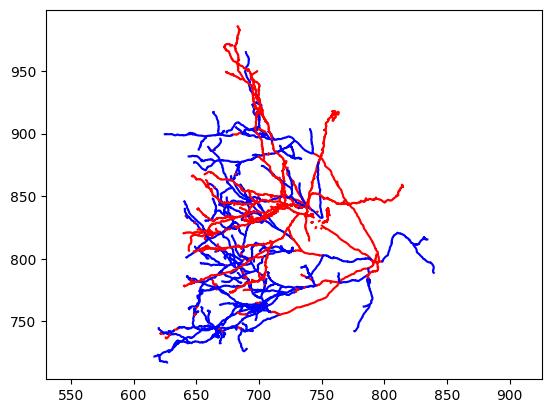

In [38]:
from matplotlib import pyplot as plt

axes = ["y", "z"]

ax_names = {"x": "x_nm", "y": "y_nm", "z": "z_nm"}
ax_idx = ["x", "y", "z"]
use_str = [ax_names[_i] for _i in axes]
use_int = [ax_idx.index(_i) for _i in axes]


m = load_morphology_with_axon_tagged(M, morph_series, tgt_id, resolve_axon_dendrite_locally)

for sec in m.iter():
    pts = sec.points[:, use_int]
    if sec.type == morphio.SectionType.axon: col = "blue"
    else: col = "red"
    plt.plot(pts[:, 0], pts[:, 1], color=col)
    
plt.axis("equal")

This heuristic is a bit better.
Instead of just counting incoming and outgoing synapses on the section locally, it considers the counts in the entire subtree rooted at that section.

But it requires the tree structure to exist, of course

In [48]:
afferent_counts = props_aff["afferent_section_id"].value_counts()

def recursive_subtree_counter(sec, local_counts):
    count_dict = {}
    this_count = 0
    if sec.id in local_counts:
        this_count = local_counts[sec.id]
    
    for child in sec.children:
        count_dict.update(recursive_subtree_counter(child, local_counts))
        this_count += count_dict[child.id]
    count_dict[sec.id] = this_count
    return count_dict

def subtree_counter(m, local_counts):
    count_dict = {}
    for sec in m.root_sections:
        count_dict.update(recursive_subtree_counter(sec, local_counts))
    return pandas.Series(count_dict)

def resolve_axon_dendrite_subtree(m, props_aff, props_eff):
    afferent_counts = props_aff["afferent_section_id"].value_counts()
    efferent_counts = props_eff["efferent_section_id"].value_counts()
    
    afferent_subtree_counts = subtree_counter(m, afferent_counts)
    efferent_subtree_counts = subtree_counter(m, efferent_counts)
    
    count_difference = afferent_subtree_counts.subtract(efferent_subtree_counts,
                                                        fill_value=0).sort_index()
    is_axon = count_difference < 0
    return is_axon


(605.4597534179687, 850.6332641601563, 703.8916717529297, 998.8303131103515)

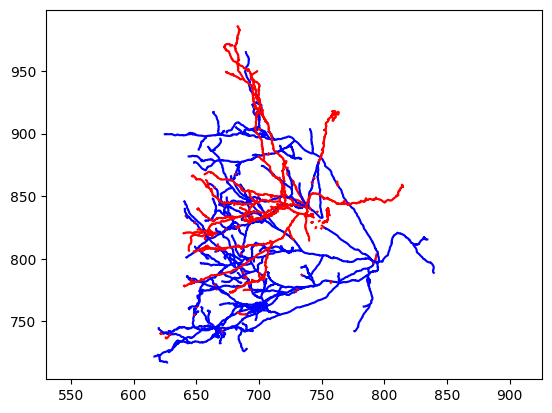

In [49]:
from matplotlib import pyplot as plt

axes = ["y", "z"]

ax_names = {"x": "x_nm", "y": "y_nm", "z": "z_nm"}
ax_idx = ["x", "y", "z"]
use_str = [ax_names[_i] for _i in axes]
use_int = [ax_idx.index(_i) for _i in axes]


m = load_morphology_with_axon_tagged(M, morph_series, tgt_id, resolve_axon_dendrite_subtree)

for sec in m.iter():
    pts = sec.points[:, use_int]
    if sec.type == morphio.SectionType.axon: col = "blue"
    else: col = "red"
    plt.plot(pts[:, 0], pts[:, 1], color=col)
    
plt.axis("equal")

Quick sanity check: dendrite diameters should be on average thicker than axon diameters.

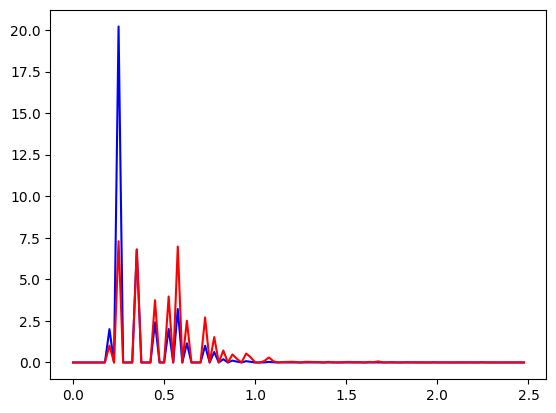

In [54]:
dendrite_diams = []
axon_diams = []
dendrite_weigths = []
axon_weights = []

for sec in m.sections:
    lengths = numpy.sqrt(numpy.sum(numpy.diff(sec.points, axis=0)**2, axis=1))
    if sec.type == morphio.SectionType.axon:
        axon_diams.extend(sec.diameters[:-1])
        axon_weights.extend(lengths)
    else:
        dendrite_diams.extend(sec.diameters[:-1])
        dendrite_weigths.extend(lengths)

bins = numpy.linspace(0, 2.5, 101)

ax = plt.figure().gca()
ax.plot(bins[:-1], numpy.histogram(axon_diams, weights=axon_weights,
                                   bins=bins, density=True)[0], color="blue")
ax.plot(bins[:-1], numpy.histogram(dendrite_diams, weights=dendrite_weigths,
                                   bins=bins, density=True)[0], color="red")